# # Table of Contents
# 
# 1. [Importación de Librerías](#import-librerias)
# 2. [Preparación de Datos](#preparacion-datos)
# 3. [Entrenamiento de Modelos con Salary](#modelos-salary)
# 4. [Entrenamiento de Modelos con Salary_log](#modelos-salary-log)
# 5. [Intervalos de Confianza](#intervalos-confianza)
# 6. [Mejora de la Inestabilidad MSE](#mejora-mse)
# 7. [Evaluación Final del Modelo](#evaluacion-final)
# 8. [Conclusión Global](#conclusion-global)

# # Importación de Librerías <a id="import-librerias"></a>

In [48]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from project_pwc.config import FIGURES_DIR

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# # Preparación de Datos <a id="preparacion-datos"></a>

In [49]:
df = pd.read_csv('C:/Users/Usuario/Documents/prueba_pwc/predictive_salary_model/data/interim/dataset_cleaned.csv')

In [50]:
df["Salary_log"] = np.log(df["Salary"])

In [51]:
df = pd.get_dummies(df, columns=["Gender"], prefix="gender", drop_first=False)

In [52]:
edu_map = {"Missing": 0, "Bachelor's": 1, "Master's": 2, "PhD": 3}
df["Education_Level_ordinal"] = df["Education Level"].map(edu_map)

In [53]:
bins = [0, 2, 7, 15, float('inf')]
labels = ["junior", "semi-senior", "senior", "expert"]
df["experience_level"] = pd.cut(df["Years of Experience"], bins=bins, labels=labels, include_lowest=True)


In [54]:
exp_map = {"junior": 0, "semi-senior": 1, "senior": 2, "expert": 3}
df["experience_level_ordinal"] = df["experience_level"].map(exp_map)

In [55]:
df.drop(columns=["experience_level", "id", "Description", "Job Title", "Age", "Education Level"], inplace=True)

In [74]:
df.head()

,Years of Experience,Salary,Salary_log,gender_Female,gender_Male,gender_Missing,Education_Level_ordinal,experience_level_ordinal
0,5,90000.0,11.407565,False,True,False,1,1
1,3,65000.0,11.082143,True,False,False,2,1
2,15,150000.0,11.918391,False,True,False,3,2
3,7,60000.0,11.002100,True,False,False,1,1
4,20,200000.0,12.206073,False,True,False,2,3


In [56]:
TARGET_COLUMN = "Salary" 
y = df[TARGET_COLUMN]

feature_cols = df.drop(columns=["Salary", "Salary_log"], errors="ignore").columns
X = df[feature_cols]

# # 3. Entrenamiento de Modelos con Salary <a id="modelos-salary"></a>
* Entrenaremos distintos modelos (Dummy, Linear, RandomForest) tomando `Salary` directamente como `y`.


In [58]:
X = df.drop(columns=["Salary", "Salary_log"], errors="ignore")
y_salary = df["Salary"] 

In [59]:
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X, y_salary, test_size=0.2, random_state=42)

In [60]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_trainA, y_trainA)
y_pred_base = baseline.predict(X_testA)

print("=== Baseline con SALARY ===")
print("MAE:", mean_absolute_error(y_testA, y_pred_base))
print("MSE:", mean_squared_error(y_testA, y_pred_base))
print("R2:", r2_score(y_testA, y_pred_base))

=== Baseline con SALARY ===
MAE: 40209.50559284116
MSE: 2403174600.7218146
R2: -0.0023325074934903434


In [61]:
lr_salary = LinearRegression()
lr_salary.fit(X_trainA, y_trainA)
y_pred_lrA = lr_salary.predict(X_testA)

print("\n=== Linear Regression (SALARY) ===")
print("MAE:", mean_absolute_error(y_testA, y_pred_lrA))
print("MSE:", mean_squared_error(y_testA, y_pred_lrA))
print("R2:", r2_score(y_testA, y_pred_lrA))


=== Linear Regression (SALARY) ===
MAE: 10802.316430539078
MSE: 222255373.93838406
R2: 0.907300207734947


In [62]:
rf_salary = RandomForestRegressor(n_estimators=100, random_state=42)
rf_salary.fit(X_trainA, y_trainA)
y_pred_rfA = rf_salary.predict(X_testA)

print("\n=== RandomForest (SALARY) ===")
print("MAE:", mean_absolute_error(y_testA, y_pred_rfA))
print("MSE:", mean_squared_error(y_testA, y_pred_rfA))
print("R2:", r2_score(y_testA, y_pred_rfA))


=== RandomForest (SALARY) ===
MAE: 10351.17812591913
MSE: 255493401.51515874
R2: 0.8934370637440111


# # 4. Entrenamiento de Modelos con Salary_log <a id="modelos-salary-log"></a>
* En esta sección entrenamos modelos tomando `Salary_log` como `y` y luego comparamos en escala real si queremos.

In [63]:
y_log = df["Salary_log"]

X_trainB, X_testB, y_trainB, y_testB = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [64]:
baseline_log = DummyRegressor(strategy='mean')
baseline_log.fit(X_trainB, y_trainB)
y_pred_baseB_log = baseline_log.predict(X_testB)

print("=== Baseline con SALARY_LOG ===")
print("MAE(log):", mean_absolute_error(y_testB, y_pred_baseB_log))
print("MSE(log):", mean_squared_error(y_testB, y_pred_baseB_log))
print("R2(log):", r2_score(y_testB, y_pred_baseB_log))

=== Baseline con SALARY_LOG ===
MAE(log): 0.4524474825951692
MSE(log): 0.27525537303634984
R2(log): -0.004641140426039803


In [65]:
lr_log = LinearRegression()
lr_log.fit(X_trainB, y_trainB)
y_pred_lrB_log = lr_log.predict(X_testB)

print("\n=== Linear Regression (SALARY_LOG) ===")
print("MAE(log):", mean_absolute_error(y_testB, y_pred_lrB_log))
print("MSE(log):", mean_squared_error(y_testB, y_pred_lrB_log))
print("R2(log):", r2_score(y_testB, y_pred_lrB_log))



=== Linear Regression (SALARY_LOG) ===
MAE(log): 0.1420740681548171
MSE(log): 0.032986879177174064
R2(log): 0.8796028010276997


In [66]:
rf_log = RandomForestRegressor(n_estimators=100, random_state=42)
rf_log.fit(X_trainB, y_trainB)
y_pred_rfB_log = rf_log.predict(X_testB)

print("\n=== RandomForest (SALARY_LOG) ===")
mae_log = mean_absolute_error(y_testB, y_pred_rfB_log)
mse_log = mean_squared_error(y_testB, y_pred_rfB_log)
r2_log = r2_score(y_testB, y_pred_rfB_log)

print("MAE(log):", mae_log)
print("MSE(log):", mse_log)
print("R2(log):", r2_log)


=== RandomForest (SALARY_LOG) ===
MAE(log): 0.10597302791226011
MSE(log): 0.02232255363699167
R2(log): 0.9185260018879734


## Convertimos las predicciones al espacio real para comparar:

In [67]:
y_testB_real = np.exp(y_testB)
y_pred_rfB = np.exp(y_pred_rfB_log)

maeB_real = mean_absolute_error(y_testB_real, y_pred_rfB)
mseB_real = mean_squared_error(y_testB_real, y_pred_rfB)
r2B_real = r2_score(y_testB_real, y_pred_rfB)

print("=== RandomForest (SALARY_LOG) en escala real ===")
print(f"MAE : {maeB_real:.2f}")
print(f"MSE : {mseB_real:.2f}")
print(f"R2  : {r2B_real:.2f}")

=== RandomForest (SALARY_LOG) en escala real ===
MAE : 10689.56
MSE : 282528641.28
R2  : 0.88


# # Intervalos de Confianza <a id="intervalos-confianza"></a>
* Calculamos MAE, MSE y R² con cross-validation y sus intervalos de confianza.

In [68]:
def confidence_intervals_all(model, X, y, cv=5, confidence=0.95):
    results = {}
    metrics = {"MAE": "neg_mean_absolute_error","MSE": "neg_mean_squared_error","R2":  "r2"}

    for metric_name, scoring_method in metrics.items():
        scores = cross_val_score(model, X, y, scoring=scoring_method, cv=cv)
        if scoring_method.startswith('neg_'):
            scores = -scores

        mean_val = np.mean(scores)
        std_val  = np.std(scores, ddof=1)
        n = len(scores)
        alpha = 1 - confidence
        t_crit = st.t.ppf(1 - alpha/2, df=n-1)
        ci_lower = mean_val - t_crit * (std_val / np.sqrt(n))
        ci_upper = mean_val + t_crit * (std_val / np.sqrt(n))

        results[metric_name] = {
            "mean": mean_val,
            "ci_lower": ci_lower,
            "ci_upper": ci_upper
        }

    return results

In [69]:
model_cv = RandomForestRegressor(random_state=42)
all_metrics = confidence_intervals_all(model_cv, X, y_salary, cv=5, confidence=0.95)
for m in ["MAE", "MSE", "R2"]:
    mean_val = all_metrics[m]["mean"]
    lower = all_metrics[m]["ci_lower"]
    upper = all_metrics[m]["ci_upper"]
    print(f"{m} (5-fold CV) = {mean_val:.3f} (95% CI: [{lower:.3f}, {upper:.3f}])")

MAE (5-fold CV) = 12199.849 (95% CI: [6926.512, 17473.185])
MSE (5-fold CV) = 323750357.532 (95% CI: [66432953.407, 581067761.656])
R2 (5-fold CV) = 0.862 (95% CI: [0.759, 0.965])


# # 6. Mejora de la Inestabilidad de MSE <a id="mejora-mse"></a>
* Uso de RepeatedKFold para obtener más estimaciones y reducir la varianza en MSE

In [70]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
scores_mse = cross_val_score(RandomForestRegressor(random_state=42), X, y_salary, scoring='neg_mean_squared_error', cv=rkf)
scores_mse = -scores_mse
print("RepeatedKFold MSE:", np.mean(scores_mse), "+/-", np.std(scores_mse))

RepeatedKFold MSE: 250877583.03737938 +/- 68876610.15532854


# # 7. Evaluación Final del Modelo <a id="evaluacion-final"></a>
* Evaluamos la variable Salary para Random Forest.

In [71]:
def evaluate_model_performance(model, X_test, y_test, filename_prefix="model_performance", model_name="MyModel"):
    y_pred = model.predict(X_test)

    plt.figure(figsize=(6,5))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color="teal")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs. Predicted ({model_name})")

    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], color="red", ls="--")

    plt.tight_layout()
    output_path = os.path.join(FIGURES_DIR, f"{filename_prefix}_actual_vs_pred.png")
    plt.savefig(output_path)
    print(f"Gráfico 'Actual vs Predicted' guardado en: {output_path}")

In [72]:
def plot_residuals(model, X_test, y_test, filename_prefix="model_performance", model_name="MyModel"):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    plt.figure(figsize=(6,4))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
    plt.axhline(0, color='red', ls='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"Residuals ({model_name})")

    plt.tight_layout()
    output_path = os.path.join(FIGURES_DIR, f"{filename_prefix}_residuals.png")
    plt.savefig(output_path)
    print(f"Gráfico 'Residuals' guardado en: {output_path}")

Gráfico 'Actual vs Predicted' guardado en: C:\Users\Usuario\Documents\prueba_pwc\predictive_salary_model\reports\figures\rf_salary_actual_vs_pred.png
Gráfico 'Residuals' guardado en: C:\Users\Usuario\Documents\prueba_pwc\predictive_salary_model\reports\figures\rf_salary_residuals.png


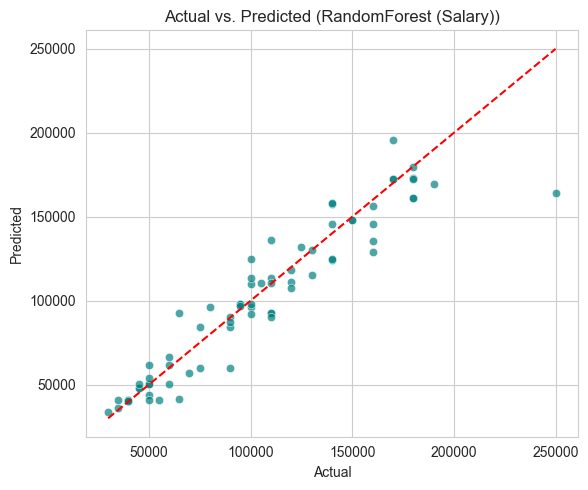

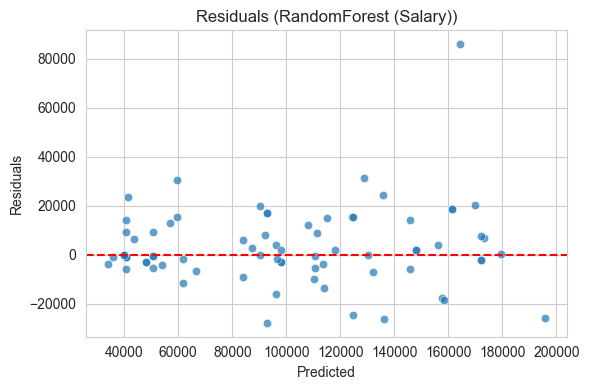

In [73]:
evaluate_model_performance(rf_salary, X_testA, y_testA, filename_prefix="rf_salary", model_name="RandomForest (Salary)")
plot_residuals(rf_salary, X_testA, y_testA, filename_prefix="rf_salary", model_name="RandomForest (Salary)")

# # 8. Conclusión Global <a id="conclusion-global"></a>

- El **modelo Baseline** (Dummy) es ineficaz, con R² ~ -0.00 y MAE extremadamente alto (~\$40k).
- **Linear Regression** y **RandomForest** ofrecen mejores resultados, con R² entre 0.89 y 0.91 al predecir SALARY directamente.
- Con `Salary_log` como target, el modelo logra un R² muy alto (0.92) en la escala logarítmica, pero al volver a la escala real, se ubica en ~0.88 de R², cerca de los valores del modelo que predice SALARY directamente.
- **Interpretación**: el dataset no parece tener outliers tan extremos como para que la transformación log marque una gran diferencia en la escala real de salarios.
- El **error MAE** ~ \$10k sugiere que en promedio el modelo se desvía \$10k del salario real. Dado que algunos salarios van hasta 200k+, este error (~5%) podría ser aceptable.
- **Intervalos de confianza** en cross-validation confirman que, en la mayoría de particiones, el modelo mantiene R²>0.75 y un MAE entre ~\$7k y \$17k, lo que indica robustez.